# Comparison of three-dimensional lower extremity kinematics in recreational runners: an inter-laboratory dataset 

This NB does the following:
* Descriptive and inferential stats of age, body height and mass
* Statistical Parametric Mapping, Rootmean square error and maximal mean values across suprathreshold SPM clusters
* Create ensemble time series curves for the groups

In [1]:
# Prepare environment
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg

%matplotlib inline

#sys.path.insert(1, r'../functions')

pd.set_option("display.precision", 2)

## Supporting stats functions

In [2]:
def ttest(df, var, factor, levels=None, alpha=0.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = pd.DataFrame()
    if levels is None:
        levels = df[factor].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for v in var:
        x = df[df[factor] == levels[0]][v]
        y = df[df[factor] == levels[1]][v]
        stat = pg.ttest(x, y)
        stat.index = [v]
        stats = pd.concat([stats, stat], axis=0)
    stats.drop(columns=['BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'p-val': '{:.3f}'}).apply(sig_red, subset='p-val', axis=1))
    return stats

def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']

def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    is_sig = col < alpha
    return ['color: red' if x else 'color: black' for x in is_sig]

def describe(df, by, var=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    display(x.style.apply(sig_red,
                          subset=[col for col in x.columns if col[1] == 'normality']))    
    return x

In [3]:
# File directories 
dir_data = r'../data' 

## Descriptive stats
### Age, height and mass

In [4]:
info = pd.read_csv(os.path.join(dir_data, 'metadata.csv'), 
                        usecols = ['ID', 'filename', 'speed', 'Age', 'Height', 
                                   'Mass', 'group'])

In [5]:
var = ['group', 'Age', 'Height', 'Mass']
describe(info[var], 'group', var=['count', 'mean', 'std', normality]);

In [6]:
stats = ttest(info, var[1:], 'group', levels=['BMC', 'RIC'])

,T,dof,alternative,p-val,CI95%,cohen-d
BMC-RIC,,,,,,
Age,0.440598,44,two-sided,0.662,[-2.49 3.88],0.129925
Height,-0.276058,44,two-sided,0.784,[-3.54 2.68],0.081405
Mass,-3.694270,44,two-sided,0.001,[-12.91 -3.79],1.089381


## Ensemble time-series, SPM and RMSE
* Create ensemble time-series curves of hip, knee and ankle joint throughout the gait cycle for each group (RBDS and RIC). 
* Perform a time-series analysis using [Statistical Parametric Mapping](http://www.scholarpedia.org/article/Statistical_parametric_mapping)
* Calculate the Root mean square error between groups to estimate the differences

In [7]:
joints = ['hip','knee','ankle']
axes   = ['X','Y','Z']
planes = ['frontal','transverse','sagittal']

In [8]:
# Import BMC curves
fns_BMC = info[info['group']=='BMC']['filename'].tolist()
R_ang_BMC = np.empty(shape=(101,len(joints)*len(axes), len(fns_BMC))) * np.NaN
for s, fn in enumerate(fns_BMC):
    angs_BMC = np.loadtxt(os.path.join(dir_data,fn), skiprows=1) 
    angs_BMC = angs_BMC[:,1:] #drop time column
    # Preallocate
    angM = np.empty(shape=(101,len(joints)*len(axes)))
    for j in range(len(joints)):
        for ax in range(len(axes)):
            angM[:,3*j+ax] = np.median(angs_BMC[:,3*j+ax:angs_BMC.shape[1]-(3*j+ax+1):len(joints)*len(axes)], axis=1)
    R_ang_BMC[:,:,s] = angM

In [9]:
fns_RIC = info[info['group']=='RIC']['filename'].tolist()
R_ang_RIC = np.empty(shape=(101,len(joints)*len(axes), len(fns_RIC))) * np.NaN
for s, fn in enumerate(fns_RIC):
    angs_RIC = np.loadtxt(os.path.join(dir_data,fn), skiprows=1) 
    angs_RIC = angs_RIC[:,1:] #drop time column
    # Preallocate
    angM = np.empty(shape=(101,len(joints)*len(axes)))
    for j in range(len(joints)):
        for ax in range(len(axes)):
            angM[:,3*j+ax] = np.median(angs_RIC[:,3*j+ax:angs_RIC.shape[1]-(3*j+ax+1):len(joints)*len(axes)], axis=1)
    R_ang_RIC[:,:,s] = angM

In [10]:
# Save the figure and show
# fig.savefig(os.path.join(dir_data, 'RMSe.png'), bbox_inches='tight')

In [11]:
# Mean and std dev across subjects
R_ang_BMCme, R_ang_BMCsd= np.mean(R_ang_BMC, axis=2), np.std(R_ang_BMC, axis=2)
R_ang_RICme, R_ang_RICsd  = np.mean(R_ang_RIC, axis=2), np.std(R_ang_RIC, axis=2)

## RMSE

In [12]:
RMSE = np.sqrt(np.square(np.subtract(R_ang_BMCme,R_ang_RICme)).mean(axis=0))
RMSEcols = [joint+'_'+ax for joint in joints for ax in axes]

In [13]:
from prettytable import PrettyTable

In [14]:
x = PrettyTable()
x.field_names = RMSEcols
x.add_row(RMSE.round(2))
print('RMSE between mean curve of each centre [degrees]')
print(x)

RMSE between mean curve of each centre [degrees]
+-------+-------+-------+--------+--------+--------+---------+---------+---------+
| hip_X | hip_Y | hip_Z | knee_X | knee_Y | knee_Z | ankle_X | ankle_Y | ankle_Z |
+-------+-------+-------+--------+--------+--------+---------+---------+---------+
|  3.63 |  3.95 |  2.0  |  2.44  |  5.0   |  1.67  |   1.41  |   1.07  |   2.39  |
+-------+-------+-------+--------+--------+--------+---------+---------+---------+


## SPM stats
Access inference objects
https://spm1d.org/doc/Stats1D/outputs.html#label-spmobject-details

In [15]:
import spm1d

## Plot angles

In [16]:
tn = np.linspace(0,100,101)

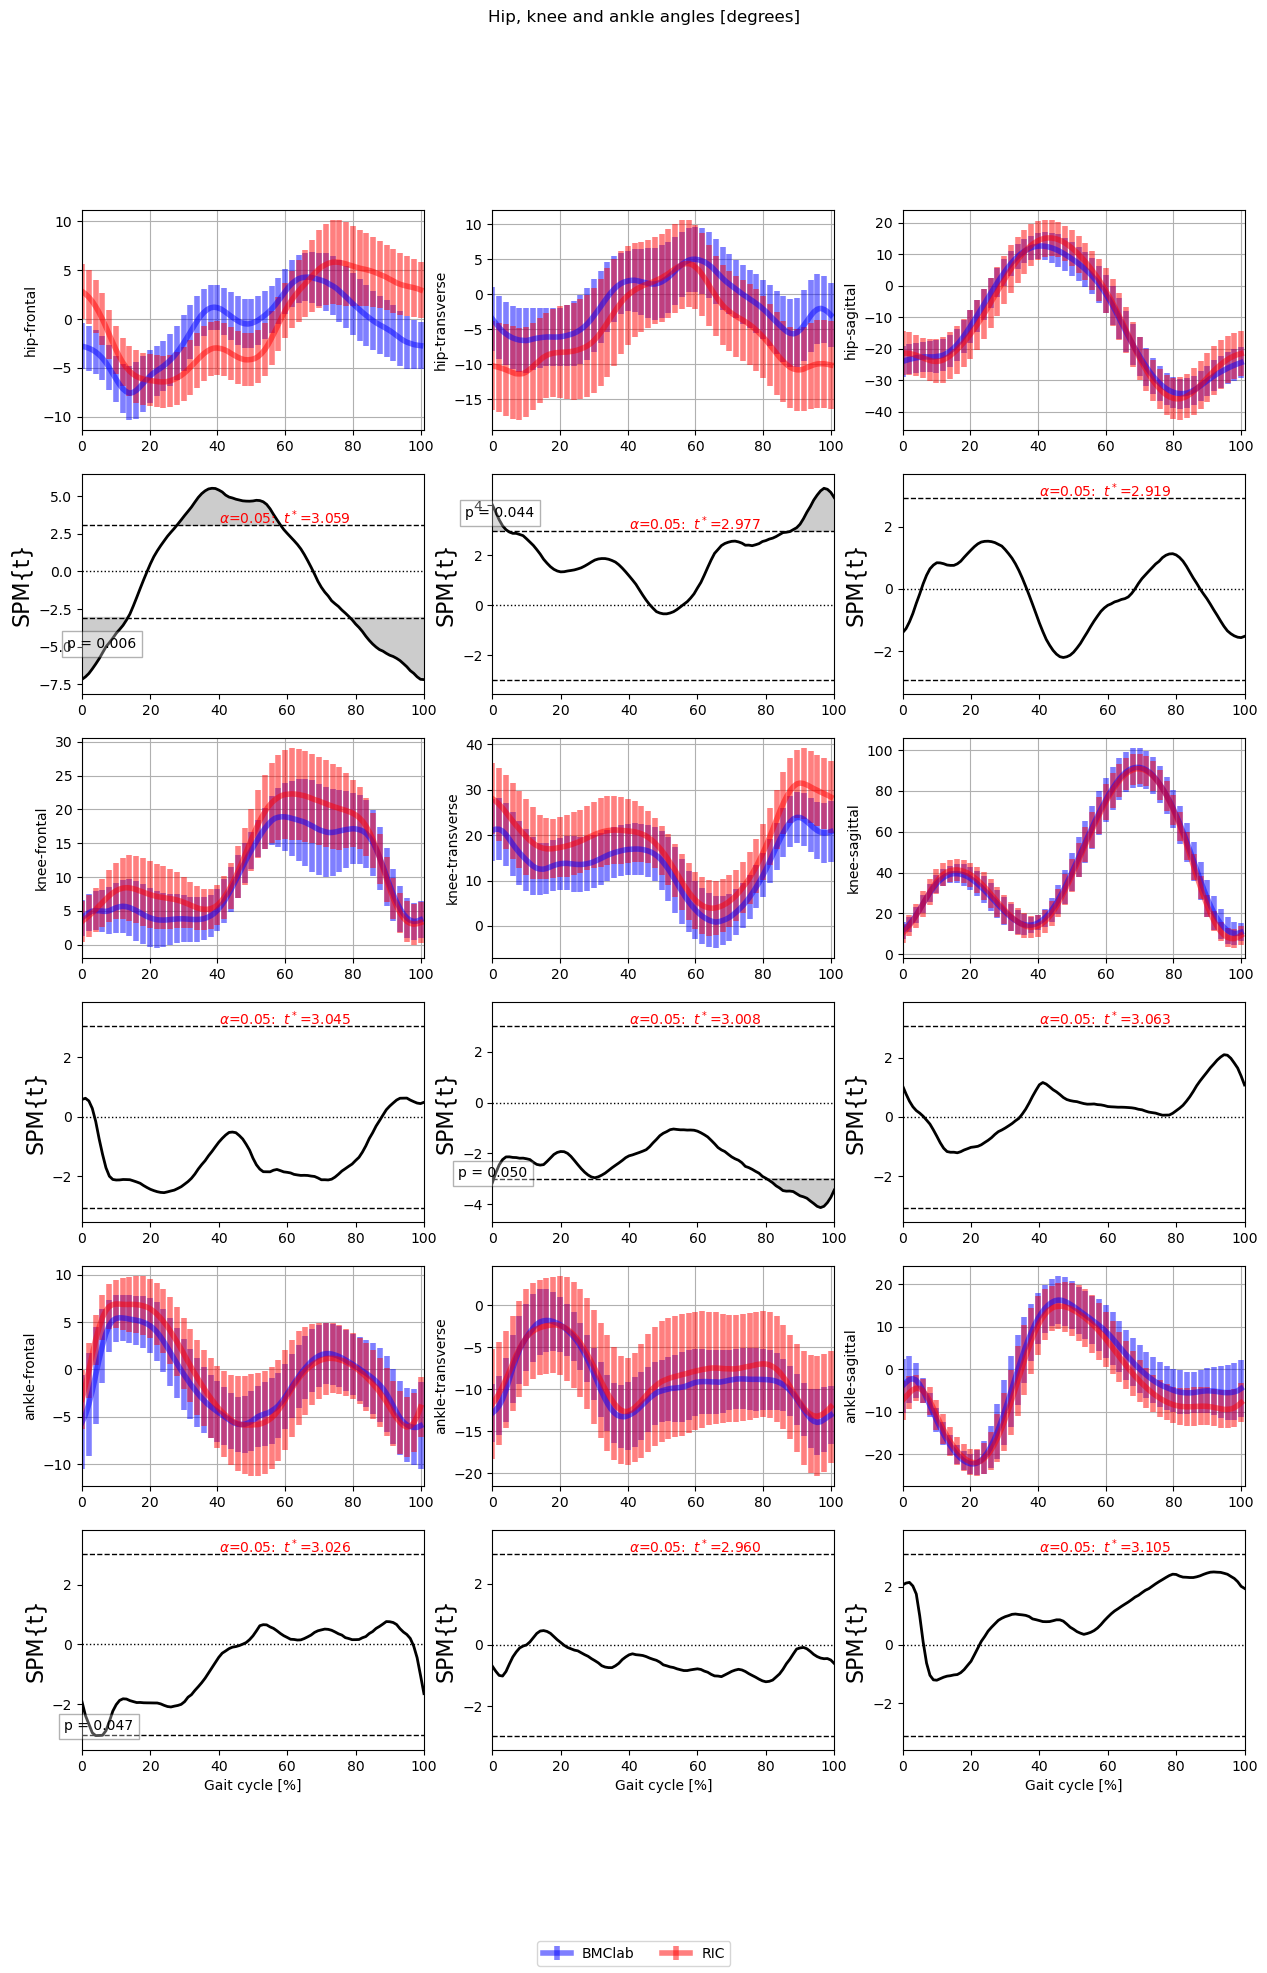

In [17]:
fig, axs = plt.subplots(6,3, figsize=(15,20))
fig.suptitle('Hip, knee and ankle angles [degrees]')
diff_max = np.empty(len(joints)*len(axes)) * np.NaN
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        axs[2*j,xyz].errorbar(tn,R_ang_BMCme[:,3*j+xyz],R_ang_BMCsd[:,3*j+xyz],
                           color = [0, 0, 1, 0.5], capsize=0, errorevery=2, lw=4)
        axs[2*j,xyz].errorbar(tn,R_ang_RICme[:,3*j+xyz],R_ang_RICsd[:,3*j+xyz],
                           color = [1, 0, 0, 0.5], capsize=0, errorevery=2, lw=4)
        axs[2*j,xyz].set_ylabel(joint+'-'+planes[xyz])
        axs[2*j,xyz].set_xlim([0,101])
        axs[2*j,xyz].grid('on')
        
        # SPM calculation
        Ymen = R_ang_BMC[:, 3*j+xyz, :]
        Yfem = R_ang_RIC[:, 3*j+xyz, :]
        t_j  = spm1d.stats.ttest2(Ymen.T, Yfem.T, 
                            equal_var=False)
        ti_j = t_j.inference(alpha=0.05, two_tailed=True, interp=True)
        ti_j.plot(ax=axs[2*j+1,xyz])
        ti_j.plot_threshold_label(ax=axs[2*j+1,xyz])
        ti_j.plot_p_values(ax=axs[2*j+1,xyz], size=10, offsets=[(0,0.3)])
        
        # Calculate maximum difference in the curve based on SPM suprathreshold clusters
        x1m = Ymen.mean(axis=1)
        x2m = Yfem.mean(axis=1)
        if ti_j.clusters:# if cluster is not empty
            max_dif = np.empty(len(ti_j.clusters))
            for i in range(len(ti_j.clusters)):
                # Get initial and end indices of suprathreshold clusters
                inds = list(map(int,map(np.ceil, ti_j.clusters[i].endpoints)))
                dif_X_Y = np.abs(x1m[inds[0]:inds[1]] - x2m[inds[0]:inds[1]])
                max_dif[i] = np.max(dif_X_Y)
            if len(max_dif) > 1:
                max_dif = np.max(max_dif)
            diff_max[3*j+xyz] = max_dif
        
        if j==2:
            axs[5,xyz].set_xlabel('Gait cycle [%]')
fig.legend(['BMClab','RIC'], loc='lower center', ncol=2)
plt.show()

## Maximum angle difference between centres
Considering the areas of the curve where suprathreshold clusters occured

In [18]:
x = PrettyTable()
x.field_names = RMSEcols
x.add_row(diff_max.round(2))
print('Max. difference in mean curves between centres in SPM suprathreshold areas')
print(x)

Max. difference in mean curves between centres in SPM suprathreshold areas
+-------+-------+-------+--------+--------+--------+---------+---------+---------+
| hip_X | hip_Y | hip_Z | knee_X | knee_Y | knee_Z | ankle_X | ankle_Y | ankle_Z |
+-------+-------+-------+--------+--------+--------+---------+---------+---------+
|  5.81 |  7.91 |  nan  |  nan   |  8.87  |  nan   |   3.75  |   nan   |   nan   |
+-------+-------+-------+--------+--------+--------+---------+---------+---------+


In [ ]:
#fig.savefig(os.path.join(dir_data, 'SPM_compare_plot_.png'), bbox_inches='tight')